# Packages and Libraries

In [1]:
import os
import json
import math
import wave
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import tensorflow as tf 
from tensorflow.keras import layers, models
import tensorflow.keras as keras

import librosa
import librosa.display
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from IPython.display import Audio
import IPython.display as display

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2024-02-15 18:57:14.619284: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 18:57:14.890755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 18:57:14.890950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 18:57:14.926510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 18:57:15.008185: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 18:57:15.009772: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Pipeline
-  `Load raw audio data` from files in .WAV format that can be processed
-  `Resample the data` resample audio data to the desired rate.
-  `Normalization` Normalize the audio signal to ensure that the amplitudes are within a specific range
-  `Trimming and Padding` Trim or pad the audio data to a consistent length
-  `Spectral Representations` Convert the audio signal into a frequency domain representation, such as a spectrogram or mel spectrogram.
-  `Augmentation` Apply data augmentation techniques to increase the diversity of the training set.
-  `Feature Scaling` Scale the features to have zero mean and unit variance.
-  `Labeling` to associate each audio clip with its corresponding label.
-  `Conversion to TensorFlow` Convert the preprocessed data into a format suitable for the deep learning framework.
-  `Data Splitting` Split the dataset into training, validation, and testing sets.
-  `Model Building` Build your machine learning model using the preprocessed data.

# Loading Raw Audio Data

The audio dataset has six(6) classes in  six subfolders with labels: 
- [ `ddyo`   `kkono`  `mu maaso`  `emabega`  `yimirira`  `gaali`]

## Mount google drive
adisamproject@gmail.com

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATASET_PATH = "/content/drive/My Drive/2_Luganda/dataset"
# data_dir = pathlib.Path(DATASET_PATH)

## Locally on the pc

In [3]:
DATASET_PATH = 'own/'
data_dir_org = pathlib.Path(DATASET_PATH)
PROCESSED_DATA_PATH = 'processedData/'

# Inspect the audio dataset

## Labels

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir_org)))
print('Commands:', commands)

Commands: ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


## Number of audio files per command

In [5]:
def count_audio_files_in_subfolders(data_dir_org):
    counts = {}

    for subfolder in os.listdir(data_dir_org):
        subfolder_path = os.path.join(data_dir_org, subfolder)

        if os.path.isdir(subfolder_path):
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count

    return counts

counts = count_audio_files_in_subfolders(data_dir_org)


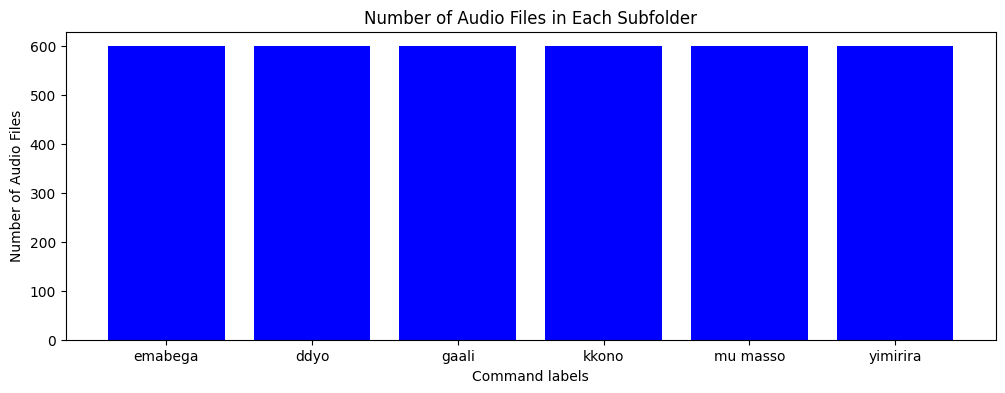

In [6]:
plt.figure(figsize=(12, 4))
plt.bar(list(counts.keys()), list(counts.values()), color='blue')
plt.xlabel('Command labels')
plt.ylabel('Number of Audio Files')
plt.title('Number of Audio Files in Each Subfolder')
plt.show()

## Audio Properties 
- using one audio file

In [7]:
example_audio_path = os.path.join(data_dir_org, 'emabega', 'audio #4251.wav')
audio_signal, sample_rate = librosa.load(example_audio_path)
audio = wave.open(example_audio_path, 'rb')

### Audio Parameters

In [8]:
SAMPLE_RATE = 22050

In [9]:
number_of_channel = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
number_of_frames = audio.getnframes()

In [10]:
print('Number of channels:', number_of_channel)
print('Sample width:',       sample_width)
print('frame rate:',         frame_rate)
print('Number of frames:',   number_of_frames)
print('Parameters:',         audio.getparams())

Number of channels: 1
Sample width: 2
frame rate: 16000
Number of frames: 20160
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=20160, comptype='NONE', compname='not compressed')


In [11]:
duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
print(f"Duration: {duration} seconds")
print(f"Sample Rate: {sample_rate} Hz")

Duration: 1.26 seconds
Sample Rate: 22050 Hz


### Visualize the audio waveform

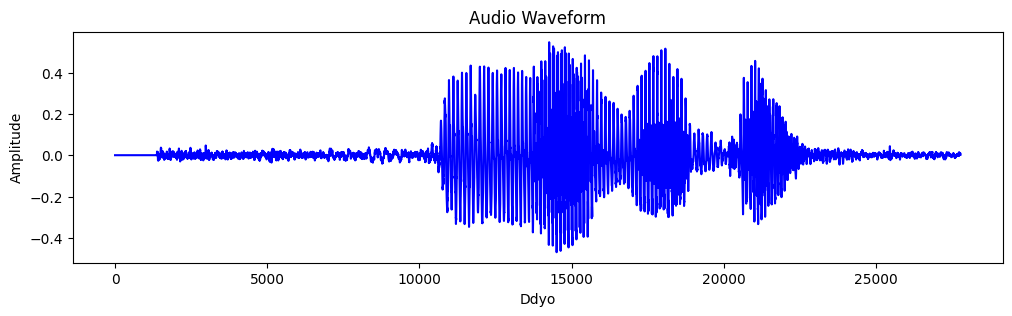

In [12]:
plt.figure(figsize=(12, 3))
plt.plot(audio_signal, color='blue')
plt.title('Audio Waveform')
plt.xlabel('Ddyo')
plt.ylabel('Amplitude')
plt.show()

### Amplitude Distribution

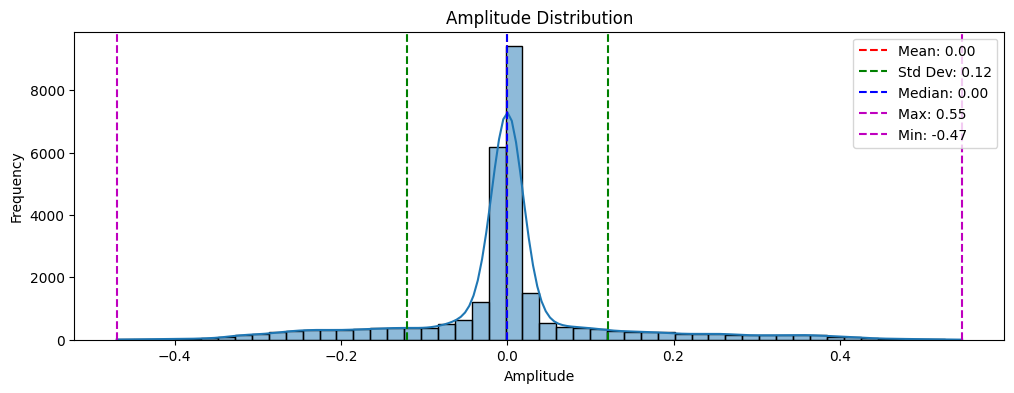

In [13]:
# Calculate statistical summary information
mean_amplitude = np.mean(audio_signal)
std_deviation = np.std(audio_signal)
max_amplitude = np.max(audio_signal)
min_amplitude = np.min(audio_signal)
median_amplitude = np.median(audio_signal)

# Plot the histogram with additional features
plt.figure(figsize=(12, 4))

# Plot the histogram
sns.histplot(audio_signal, bins=50, kde=True)

# Add vertical lines for statistical summary information
plt.axvline(mean_amplitude, color='r', linestyle='--', label=f'Mean: {mean_amplitude:.2f}')
plt.axvline(mean_amplitude + std_deviation, color='g', linestyle='--', label=f'Std Dev: {std_deviation:.2f}')
plt.axvline(mean_amplitude - std_deviation, color='g', linestyle='--')
plt.axvline(median_amplitude, color='b', linestyle='--', label=f'Median: {median_amplitude:.2f}')
plt.axvline(max_amplitude, color='m', linestyle='--', label=f'Max: {max_amplitude:.2f}')
plt.axvline(min_amplitude, color='m', linestyle='--', label=f'Min: {min_amplitude:.2f}')

# Set plot title and labels
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Play audio file

In [14]:
def play_audio(audio_signal, sample_rate):
    return Audio(audio_signal, rate=sample_rate)

play_audio(audio_signal, SAMPLE_RATE)

# Preprocessing audio dataset

## Trim and Pad

In [15]:
def process_audio(audio_path, desired_duration=2):
    # Load audio file
    audio_signal, sample_rate = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True)

    # Pad or trim audio to desired duration
    desired_samples = int(desired_duration * sample_rate)
    if len(audio_signal) < desired_samples:
        # Pad the audio to desired duration
        pad_amount = desired_samples - len(audio_signal)
        processed_signal = np.pad(audio_signal, (0, pad_amount))
    else:
        # Trim the audio to desired duration
        processed_signal = audio_signal[:desired_samples]

    return processed_signal, sample_rate


In [16]:
def preprocess_audio_in_subfolders(root_folder, output_folder, desired_duration=2):
    # Iterate through subfolders
    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Create output subfolder if it doesn't exist
            output_subfolder = os.path.join(output_folder, subfolder)
            os.makedirs(output_subfolder, exist_ok=True)

            # Iterate through audio files in the subfolder
            for audio_file in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, audio_file)

                # Process each audio file (trim or pad to desired duration)
                processed_audio, sample_rate = process_audio(audio_path, desired_duration)

                # Save the preprocessed audio file in the output subfolder using soundfile
                output_audio_path = os.path.join(output_subfolder, audio_file)
                sf.write(output_audio_path, processed_audio, sample_rate)

### New Path

In [17]:
root_folder = data_dir_org
output_folder = PROCESSED_DATA_PATH
preprocess_audio_in_subfolders(root_folder, output_folder, desired_duration=2)
data_dir = pathlib.Path(PROCESSED_DATA_PATH)

## Inspect Processed dataset

In [18]:
example_audio_path = os.path.join(PROCESSED_DATA_PATH, 'emabega', 'audio #4251.wav')
audio_signal, sample_rate = librosa.load(example_audio_path)
audio = wave.open(example_audio_path, 'rb')

In [19]:
number_of_channel = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
number_of_frames = audio.getnframes()

In [20]:
print('Number of channels:', number_of_channel)
print('Sample width:',       sample_width)
print('frame rate:',         frame_rate)
print('Number of frames:',   number_of_frames)
print('Parameters:',         audio.getparams())

Number of channels: 1
Sample width: 2
frame rate: 22050
Number of frames: 44100
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=44100, comptype='NONE', compname='not compressed')


In [21]:
duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
print(f"Duration: {duration} seconds")
print(f"Sample Rate: {sample_rate} Hz")

Duration: 2.0 seconds
Sample Rate: 22050 Hz


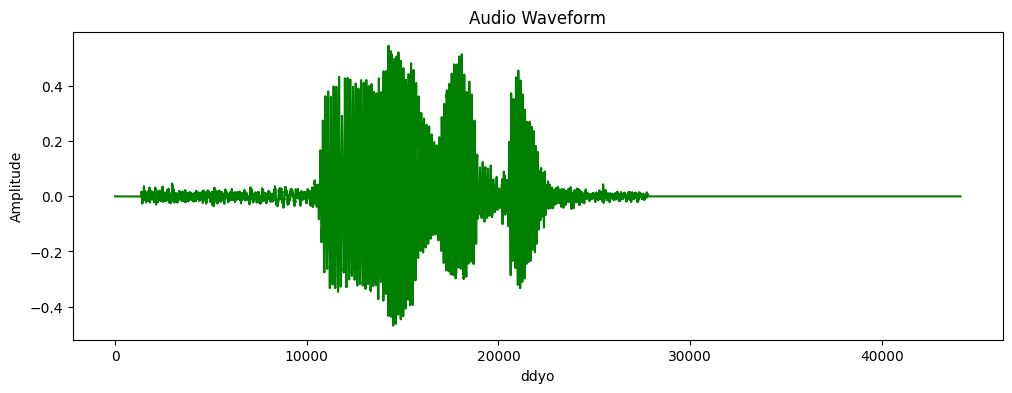

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(audio_signal, color='green')
plt.title('Audio Waveform')
plt.xlabel('ddyo')
plt.ylabel('Amplitude')
plt.show()

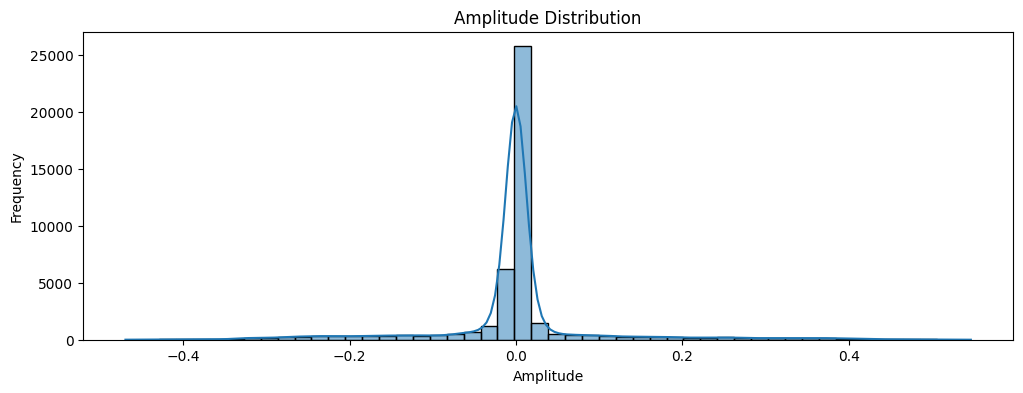

In [23]:
plt.figure(figsize=(12, 4))
sns.histplot(audio_signal, bins=50, kde=True)
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.show()


In [24]:
def play_audio(audio_signal, sample_rate):
    return Audio(audio_signal, rate=sample_rate)

play_audio(audio_signal, SAMPLE_RATE)

# Feature Extraction 

## Extracting MFCCS

In [25]:
def extract_features(root_folder, n_mfcc=13, hop_length=512, n_fft=1024):
    features = []
    labels = []

    for foldername in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, foldername)

        if os.path.isdir(folder_path):
            for audio_filename in os.listdir(folder_path):
                audio_path = os.path.join(folder_path, audio_filename)

                # Load audio file and extract features
                try:
                    audio_signal, sample_rate = librosa.load(audio_path, sr=None)  # Remove duration parameter
                    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
                    mfccs_mean = np.mean(mfccs, axis=1)  # Take the mean of MFCCs over time
                    features.append(mfccs_mean)
                    labels.append(foldername)  # Assuming folder names are the labels/categories
                except Exception as e:
                    print(f"Error encountered while processing {audio_path}: {e}")

    return np.array(features), np.array(labels)


In [26]:
features, labels = extract_features(data_dir, n_mfcc=13, hop_length=512, n_fft=1024)

In [27]:
# Display the shape of the extracted features and labels
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print(labels)

Features shape: (3600, 13)
Labels shape: (3600,)
['emabega' 'emabega' 'emabega' ... 'yimirira' 'yimirira' 'yimirira']


## Plot MFCC

In [28]:
def plot_mfcc(mfccs, sample_rate=22050, hop_length=512):
    mfccs_normalized = librosa.util.normalize(mfccs)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs_normalized, sr=sample_rate, hop_length=hop_length, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Normalized MFCCs')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.show()



In [29]:
audio_signal, sample_rate = librosa.load(example_audio_path, sr=SAMPLE_RATE)
mfccs = librosa.feature.mfcc(y=audio_signal, sr=SAMPLE_RATE, n_mfcc=13, hop_length=hop_length, n_fft=1024)
plot_mfcc(mfccs)


NameError: name 'hop_length' is not defined

# Data augmentation

In [ ]:
def augment_data(features, labels, speed_factors, sample_rate):
    augmented_features = []
    augmented_labels = []

    for idx, feature in enumerate(features):
        for speed_factor in speed_factors:
            # Time stretch the audio feature
            augmented_feature = librosa.effects.time_stretch(feature, rate=speed_factor)
            # Resample the augmented feature to match the original sample rate
            augmented_feature = librosa.resample(augmented_feature, orig_sr=len(augmented_feature), target_sr=sample_rate)
            augmented_features.append(augmented_feature)
            augmented_labels.append(labels[idx])

    return np.array(augmented_features), np.array(augmented_labels)



In [ ]:
# Example usage:
speed_factors = [0.9, 1.1]  # Adjust as needed
augmented_features, augmented_labels = augment_data(features, labels, speed_factors, sample_rate)


In [ ]:
augmented_features.shape

# Feature Scaling

In [ ]:
def scale_features(features):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    return scaled_features

scaled_features = scale_features(augmented_features)


In [ ]:
scaled_features.shape

# Splitting data

In [ ]:
def split_data(features, labels, test_size=0.2, validation_size=0.1):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size/(1-test_size), random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [49]:
# Example usage:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(scaled_features, augmented_labels)


In [50]:
X_train.shape

(5040, 22050)

In [51]:
X_val.shape

(720, 22050)

In [52]:
X_test.shape

(1440, 22050)

In [53]:
from sklearn.preprocessing import LabelEncoder

# Convert labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Model Building

In [60]:
# Define the model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=X_train[0].shape),
    Dropout(0.5),
    Dense(len(set(labels)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_val, y_val_encoded))


Epoch 1/10
158/158 [==============================] - 3s 15ms/step - loss: 8.2328 - accuracy: 0.6149 - val_loss: 2.1692 - val_accuracy: 0.8125
Epoch 2/10
158/158 [==============================] - 2s 14ms/step - loss: 5.0987 - accuracy: 0.7389 - val_loss: 1.6608 - val_accuracy: 0.8528
Epoch 3/10
158/158 [==============================] - 2s 14ms/step - loss: 4.2397 - accuracy: 0.7627 - val_loss: 1.0585 - val_accuracy: 0.9000
Epoch 4/10
158/158 [==============================] - 2s 14ms/step - loss: 3.1731 - accuracy: 0.8050 - val_loss: 0.9460 - val_accuracy: 0.9153
Epoch 5/10
158/158 [==============================] - 2s 14ms/step - loss: 2.7003 - accuracy: 0.8038 - val_loss: 0.6903 - val_accuracy: 0.9278
Epoch 6/10
158/158 [==============================] - 2s 14ms/step - loss: 2.1198 - accuracy: 0.8280 - val_loss: 0.8930 - val_accuracy: 0.9042
Epoch 7/10
158/158 [==============================] - 2s 13ms/step - loss: 1.8676 - accuracy: 0.8363 - val_loss: 0.5515 - val_accuracy: 0.9375

In [66]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val_encoded)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

23/23 [==============================] - 0s 3ms/step - loss: 0.3820 - accuracy: 0.9403
Test loss: 0.3819790780544281, Test accuracy: 0.9402777552604675


In [61]:
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)

23/23 [==============================] - 0s 3ms/step - loss: 0.3820 - accuracy: 0.9403


In [63]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = y_test.reshape(-1, 1) 

45/45 [==============================] - 0s 2ms/step


In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

# Now both y_true_encoded and y_pred_encoded should contain numerical labels
# Proceed to compute the confusion matrix using these numerical labels
conf_matrix = confusion_matrix(y_true_encoded, y_pred_encoded)



# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


/home/vx/Desktop/allenv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: y contains previously unseen labels: '2'

# Split into Train and validation

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

## The shape of the audio clip
- `(batch, samples, channels)`

In [ ]:
train_ds.element_spec

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

### Plot a few audio waveforms:

In [ ]:
label_names[[0,1,2,3,4,5]]

In [ ]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

# Extract Spectrograms

In [ ]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=SAMPLE_RATE))

### Displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform over time and the corresponding spectrogram.

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, SAMPLE_RATE])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets from the audio datasets:

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [ ]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

 `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds

# Building Models

## Model 1

1. **Input Layer:** Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer:** Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer:** Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers:** Two Conv2D layers with ReLU activation functions, followed by max pooling.
5. **Dropout Layer:** Applies dropout regularization to prevent overfitting.
6. **Flatten Layer:** Flattens the output of the previous layer into a 1D vector.
7. **Dense Layers:** Two Dense layers with ReLU activation functions, followed by the output layer with logits for each class.

### Model Arch

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

### Compile the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

### Plot Accuracy and Loss

In [ ]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

### Display a confusion matrix

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 2


1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer**: Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer**: Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers**:
   - 4.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size and ReLU activation function.
   - 4.2. Batch Normalization Layer: Normalizes the activations of the previous convolutional layer.
   - 4.3. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
5. **Convolutional Layers**:
   - 5.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size and ReLU activation function.
   - 5.2. Batch Normalization Layer: Normalizes the activations of the previous convolutional layer.
   - 5.3. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
6. **Dropout Layer**: Applies dropout regularization with a dropout rate of 0.25 to prevent overfitting.
7. **Flatten Layer**: Flattens the output of the previous layer into a 1D vector.
8. **Dense Layers**:
   - 8.1. First Dense Layer: Applies 128 neurons with ReLU activation function.
   - 8.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 8.3. Second Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Model Arch

In [ ]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model2.summary()


### Compile the  Model

In [ ]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

timizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


### Train the Model

In [ ]:
EPOCHS = 10
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

### Plot Accuracy and Loss

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [ ]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

### Display a confusion matrix

In [ ]:
y_pred = model2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 3

1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Convolutional Layers**:
   - 2.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 2.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
3. **Convolutional Layers**:
   - 3.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 3.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
4. **Convolutional Layers**:
   - 4.1. Third Conv2D Layer: Applies 128 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 4.2. GlobalAveragePooling2D Layer: Performs global average pooling to reduce spatial dimensions.
5. **Dense Layers**:
   - 5.1. Dense Layer: Applies 128 neurons with ReLU activation function.
   - 5.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 5.3. Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Model Arch

In [ ]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model3.summary()


### Model compile

In [ ]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [ ]:
EPOCHS = 10
history = model3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

### Plot Loaa and accuracy

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [ ]:
model3.evaluate(test_spectrogram_ds, return_dict=True)

### Display a confusion matrix

In [ ]:
y_pred = model3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Exporting a model

## Export the model with preprocessing

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, SAMPLE_RATE], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLE_RATE,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [ ]:
export = ExportModel(model)
export(tf.constant(str('own/ddyo/audio #2001.wav')))

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])